In [1]:
%load_ext autoreload
%autoreload 2

# === Standard Libraries ===
import os
import sys
import random
import json
from typing import Any

# === Scientific Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


# === Signal Processing ===
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt, correlate

# === Seismology Libraries ===
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# === Machine Learning Libraries ===
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === File Handling ===
import h5py

# === Custom Modules ===
module_path = os.path.abspath(os.path.join('../scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.model_selection import train_test_split
from neural_network_architectures import (
     QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d )


# === Seismology Client ===
client = Client('IRIS')

from utils import extract_waveforms
from utils import compute_spectrogram
from utils import normalize_spectrogram_minmax
from utils import return_train_val_loaders
from utils import plot_confusion_matrix_and_cr
from utils import train_model
from utils import WaveformPreprocessor


import json

cuda


In [2]:
## seisbench was run on BH and HH channels only. 
exotic = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
exotic = exotic[exotic["station_channel_code"] == "BH"]
exotic = exotic[exotic["source_type"] == "surface event"]
exotic

,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db
356,pnsn3179093,surface event,CC,BH,VALT,--,46.214,-122.189,1681.0,"bucket1$1,:3,:18001",100,2021-12-19T07:32:46.000000Z,NaN,NaN,7000.0,emergent,-2.019|1.492|-1.325
357,pnsn3179088,surface event,CC,BH,HOA,--,46.242,-122.192,1151.0,"bucket1$2,:3,:18001",100,2021-12-19T07:28:28.000000Z,NaN,NaN,7000.0,emergent,6.657|-3.429|8.158
359,pnsn3177563,surface event,CC,BH,SEP,--,46.200,-122.191,2114.0,"bucket1$4,:3,:18001",100,2021-12-07T09:43:56.000000Z,NaN,NaN,7000.0,emergent,-0.222|6.356|2.264
360,pnsn3177488,surface event,CC,BH,SUG,--,46.215,-122.176,1864.0,"bucket1$5,:3,:18001",100,2021-12-06T23:48:51.000000Z,NaN,NaN,7000.0,emergent,5.281|8.824|18.920
361,pnsn3177373,surface event,CC,BH,SEP,--,46.200,-122.191,2114.0,"bucket1$6,:3,:18001",100,2021-12-06T19:07:29.000000Z,NaN,NaN,7000.0,emergent,7.326|6.831|12.713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593,pnsn1447848,surface event,UW,BH,LON,--,46.751,-121.810,853.0,"bucket1$7322,:3,:18001",100,2004-12-20T12:29:40.000000Z,8000.0,impulsive,NaN,NaN,-1.936|-10.131|-4.605
7643,pnsn907303,surface event,CC,BH,STD,--,46.237,-122.224,1189.0,"bucket1$7372,:3,:18001",100,2005-02-07T09:11:46.000000Z,NaN,NaN,7000.0,impulsive,0.118|-0.895|-1.065
7647,pnsn907303,surface event,CC,BH,JRO,--,46.275,-122.218,1219.0,"bucket1$7376,:3,:18001",100,2005-02-07T09:11:49.000000Z,NaN,NaN,7000.0,impulsive,2.530|8.407|11.947
7664,pnsn1201233,surface event,CC,BH,WIFE,--,44.060,-121.817,1955.0,"bucket1$7393,:3,:18001",100,2004-11-08T10:48:28.000000Z,NaN,NaN,7000.0,impulsive,5.799|-1.771|5.948


In [3]:
event = exotic.iloc[11]
network = event["station_network_code"]
station = event["station_code"]
channel = event["station_channel_code"]
starttime = obspy.UTCDateTime(event["trace_start_time"])
print(event)

event_id                                  pnsn3173148
source_type                             surface event
station_network_code                               CC
station_channel_code                               BH
station_code                                      SEP
station_location_code                              --
station_latitude_deg                             46.2
station_longitude_deg                        -122.191
station_elevation_m                            2114.0
trace_name                       bucket1$62,:3,:18001
trace_sampling_rate_hz                            100
trace_start_time          2021-10-14T01:27:47.000000Z
trace_S_arrival_sample                            NaN
trace_S_onset                                     NaN
trace_P_arrival_sample                         7000.0
trace_P_onset                                emergent
trace_snr_db                      4.385|-4.590|-3.941
Name: 417, dtype: object


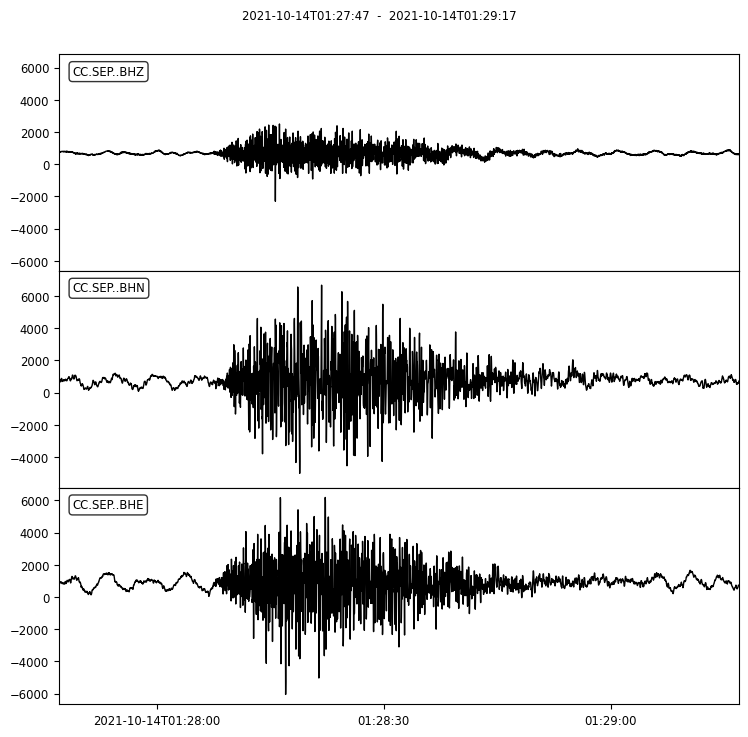

In [9]:
## Downloading the data 
st = client.get_waveforms(network=network, station=station, channel=f"{channel}?", location="--",
                         starttime=starttime+0, endtime=starttime+90)



st.plot();

In [10]:
st

3 Trace(s) in Stream:
CC.SEP..BHE | 2021-10-14T01:27:47.000000Z - 2021-10-14T01:29:17.000000Z | 50.0 Hz, 4501 samples
CC.SEP..BHN | 2021-10-14T01:27:47.000000Z - 2021-10-14T01:29:17.000000Z | 50.0 Hz, 4501 samples
CC.SEP..BHZ | 2021-10-14T01:27:47.000000Z - 2021-10-14T01:29:17.000000Z | 50.0 Hz, 4501 samples

In [21]:
model_input = torch.tensor(np.array(st), dtype = torch.float32).unsqueeze(0)

In [22]:
processor = WaveformPreprocessor(input_fs = 50, target_fs = 50, lowcut = 1, highcut = 20, order = 4, taper_alpha = 0.1)

In [33]:
detrended_local = processor._linear_detrend(model_input)
tapered_local = processor._taper_tukey(detrended_local)
filtered_local = processor._bandpass_filter(tapered_local, 50, 1, 20, 4)
resampled_local = processor._resample(filtered_local, 50, 50)
normalized_local = processor._normalize_per_trace(resampled_local)

In [34]:
detrended_seisbench = torch.load('../seisbench_output/detrended_seisbench.pt')
tapered_seisbench = torch.load('../seisbench_output/tapered_seisbench.pt')
filtered_seisbench = torch.load('../seisbench_output/filtered_seisbench.pt')
resampled_seisbench = torch.load('../seisbench_output/resampled_seisbench.pt')
normalized_seisbench = torch.load('../seisbench_output/normalized_seisbench.pt')

/tmp/ipykernel_657715/2475986498.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  detrended_seisbench = torch.load('../seisbench_output/detrended_seisbench.pt')
/tmp/ipyk

tensor([[[ 170.8786,  125.8618,  112.8450,  ..., -164.9302, -169.9470,
          -175.9637],
         [  45.8421,   45.8030,   56.7638,  ..., -200.7782, -175.8174,
          -130.8565],
         [ -17.0024,   10.9968,   -9.0040,  ...,  -67.1423,  -41.1431,
           -87.1440]]])